<a href="https://colab.research.google.com/github/akd18/DS-SL/blob/main/Healthcare_Diabetes%20Project(NIDDK)/Healthcare_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this project is to build a model to accurately predict whether the patients have diabetes or not.

# Importing the Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
!pip install --quiet optuna

In [ ]:
import xgboost as xgb
import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/Practice n Projects/Simplilearn - Data Science Capstone/Healthcare"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Practice n Projects/Simplilearn - Data Science Capstone/Healthcare


In [ ]:
data_raw = pd.read_csv('./Healthcare - Diabetes/health care diabetes.csv')
data_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


It is a Classification Projecr and the dataset has 8 features and 'Outcome' being the label(to be predicted).

# Analysing the Data

In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


There are 768 entries and there are no Null values in the dataset.

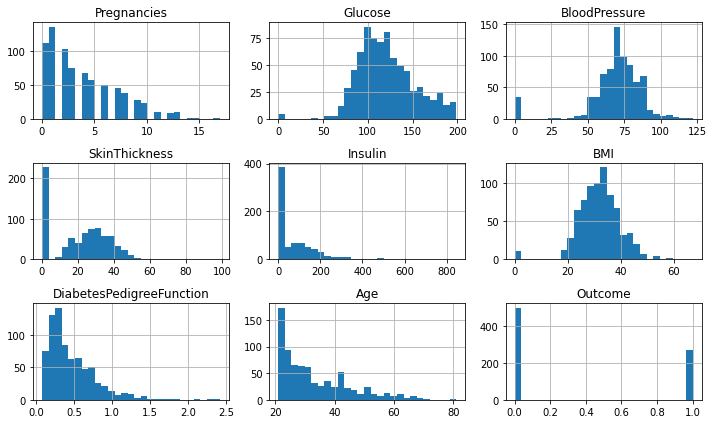

In [ ]:
data_raw.hist(figsize=(10,6),bins=int(len(data_raw)**(1/2)))
plt.tight_layout()

In [ ]:
data_raw['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

 - We can see that the dataset is mildly imbalanced. We have to keep this in mind while modeling and choosing an evaluation metric.
 - There seems to be alot of zeros in certain features that doesnt make much sense.

A value of zero does not make sense and thus indicates missing values in : Glucose, BloodPressure, SkinThickness, Insulin & BMI.
We shall replace zeros with null values.

Before we continue, 
*   We shall create a copy of the data so that we dont disturb the original dataset.
*   Create a **Train-Test Split** and set aside the testing set for final validation.



In [ ]:
data = data_raw.copy()

pd.set_option('mode.chained_assignment',None)
missingVal_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data.loc[:,missingVal_cols] = data.loc[:,missingVal_cols].replace(0,pd.NA)

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=21)
data = pd.concat([X_train, y_train],axis=1)
eval = pd.concat([X_test, y_test],axis=1)

Henceforth, we will only be using the training set (data, X_train & y_train) for analysis and model training.


In [ ]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,611.000000,586.000000,432.000000,308.000000,605.000000,614.000000,614.000000,614.000000
mean,3.996743,121.924714,72.984642,29.039352,160.512987,32.518182,0.468147,33.757329,0.348534
std,3.378754,30.662749,12.504007,10.416426,123.981150,7.067843,0.331779,11.819389,0.476895
min,0.000000,44.000000,30.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,21.000000,78.500000,27.500000,0.246250,24.000000,0.000000
50%,3.000000,116.000000,74.000000,29.000000,130.000000,32.000000,0.364500,30.000000,0.000000
75%,6.000000,141.500000,80.000000,36.000000,194.000000,36.600000,0.626750,41.000000,1.000000
max,14.000000,197.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- Now we have 614 entries and some features have missing values.
- There also seems to exist some outliers in some features.

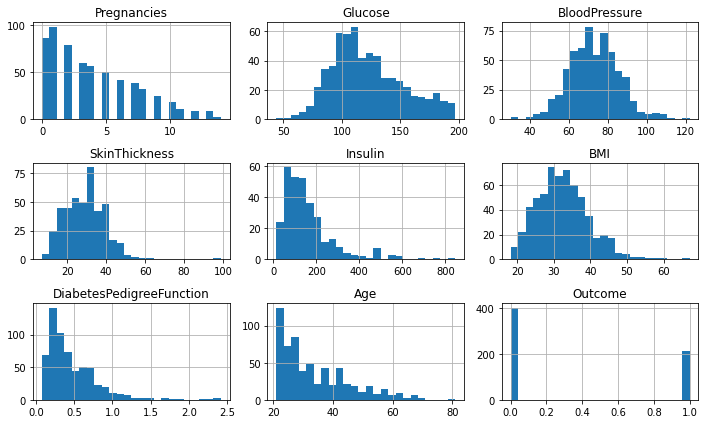

In [ ]:
data.hist(figsize=(10,6),bins=int(len(data)**(1/2)))
plt.tight_layout()

- Most features seem more or less Normally distributed after marking the missing values.

In [ ]:
def missing_count(data):
  print("Number of Instances : ",len(data))
  print("Number of Missing Values in :")
  for feature in data.columns:
    if data[feature].isin([np.nan]).sum()>1:
      print(f"  - {feature} :", data[feature].isna().sum(),f"({data[feature].isna().sum()*100/len(data):0.2f} %)")

missing_count(data)

Number of Instances :  614
Number of Missing Values in :
  - Glucose : 3 (0.49 %)
  - BloodPressure : 28 (4.56 %)
  - SkinThickness : 182 (29.64 %)
  - Insulin : 306 (49.84 %)
  - BMI : 9 (1.47 %)


- The features 'Insulin' and 'BloodPressure' has a concerning amount of missing values.

I dont want to drop the whole feature as it is because, from a basic understanding i feel that Insulin levels and Blood Pressure are important parameters with respect to Diabetes. 

We will drop the entries that has missing values in other columns and will try to impute the missing values for these 5 columns. But before that we could also try algorithms that can handle datasets with missing values.

In [ ]:
data.drop(data[data.Glucose.isna() | data.BloodPressure.isna() | data.BMI.isna()].index,axis='index',inplace=True)
missing_count(data)

Number of Instances :  579
Number of Missing Values in :
  - SkinThickness : 154 (26.60 %)
  - Insulin : 272 (46.98 %)


In [ ]:
def col_violinplots(data):
    data=data
    cols = data.columns
    fig, ax = plt.subplots(int(np.ceil(len(cols)/4)),4,figsize=(20,12))
    axes=ax.flatten()
    for i,a in enumerate(axes):
        if i+1>=len(cols):
            fig.delaxes(a)
    for i,feature in enumerate(cols[:-1]):
        sns.violinplot(data=data,x='Outcome',y=feature,ax=axes[i],dodge=False,orient='v',cut=0)
        axes[i].set_title(feature,fontsize=20)
    fig.tight_layout()

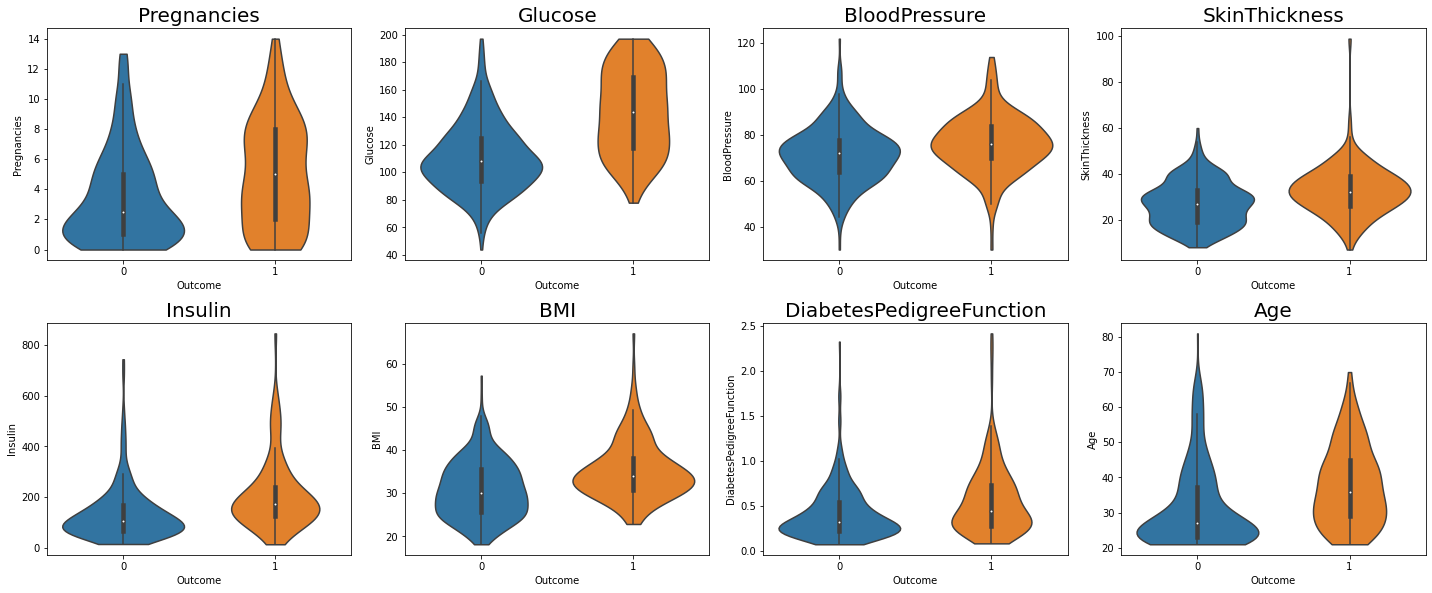

In [ ]:
col_violinplots(data)

- The distribution of the various features for diabetes positive(Outcome=1) and negative(Outcome=1) seems distinct for atleast some of the features.

Pregnancies and Age are discrete variables.

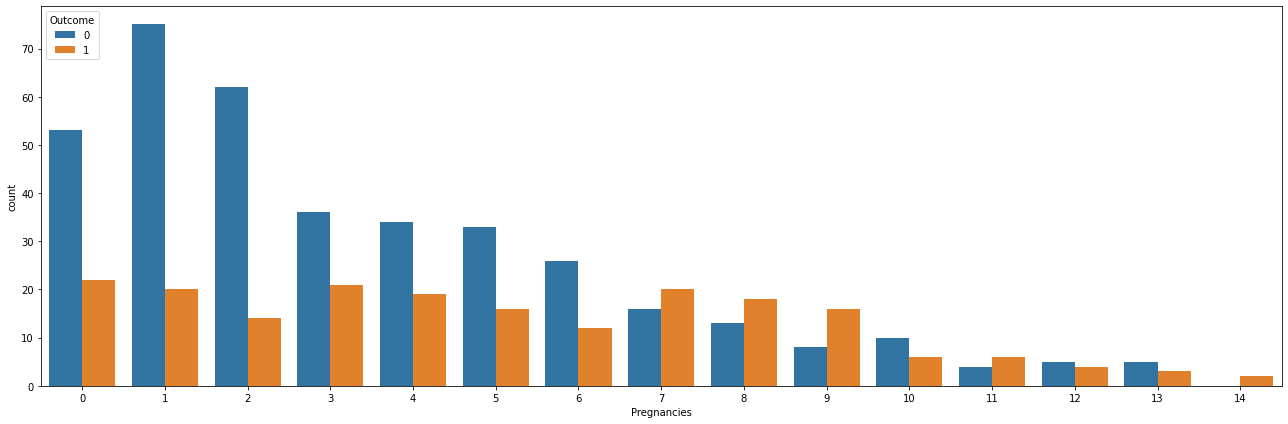

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
sns.countplot(data=data,x='Pregnancies',hue='Outcome',order=(data.Age.values).sort())
fig.tight_layout()

- The number of pregnancies in the dataset reaches upto 14 in the dataset. These are outliers.

Though this number is not impossible, but its highly unlikely and is towards the extreme. 

In [ ]:
print("- Instances with Pregnancies greater than 10 : ", (data.Pregnancies >10).sum())
print("- Instances among these with Missing Values  :",(data[data.Pregnancies >10].isna().apply(sum,axis='columns')>0).sum())

- Instances with Pregnancies greater than 10 :  29
- Instances among these with Missing Values  : 15


- There are 29 instances of more than 10 Pregnancies in a dataset of 579. Also, within these, 15 instances have missing values.

In [ ]:
def outliers_iqr(data):  
  '''Takes in Series/Array-like and returns indexes of outliers'''
  
  q1 = np.percentile(data,25)
  q3 = np.percentile(data,75)
  iqr = q3-q1
  u_limit = q3 + 1.5*iqr
  l_limit = q1 - 1.5*iqr

  return data[(data>u_limit) | (data<l_limit)].index.tolist()

In [ ]:
outliers_index = data.apply(outliers_iqr,axis='index')
outliers_index.apply(len)

Pregnancies                  2
Glucose                      0
BloodPressure               12
SkinThickness                0
Insulin                      0
BMI                          7
DiabetesPedigreeFunction    18
Age                          6
Outcome                      0
dtype: int64

- BloodPressure and DiabetesPedigreeFunction has a high amount of outliers.

The pressence of outliers should also be taken into consideration when modeling.

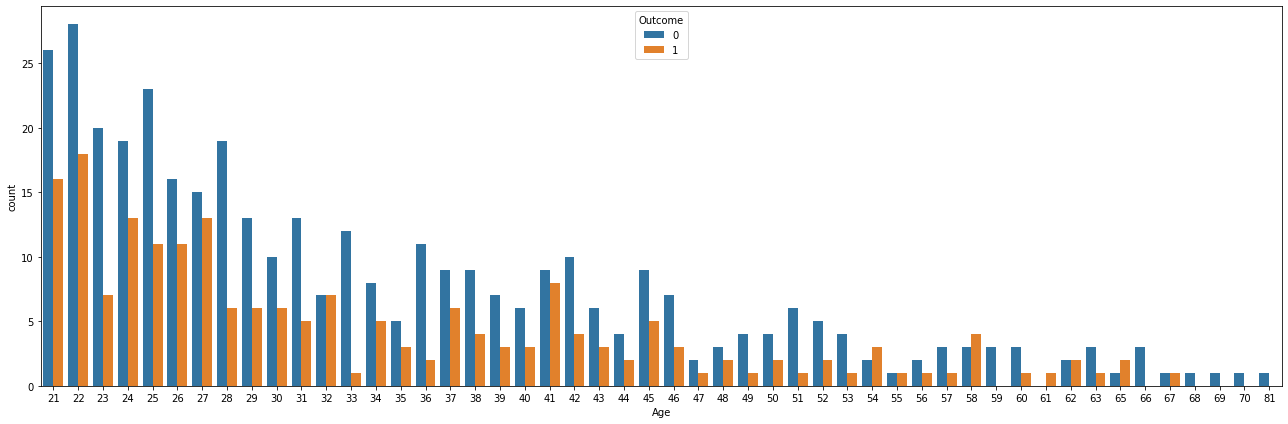

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
sns.countplot(data=data,x='Age',hue='Outcome',order=(data.Age.values).sort())
fig.tight_layout()

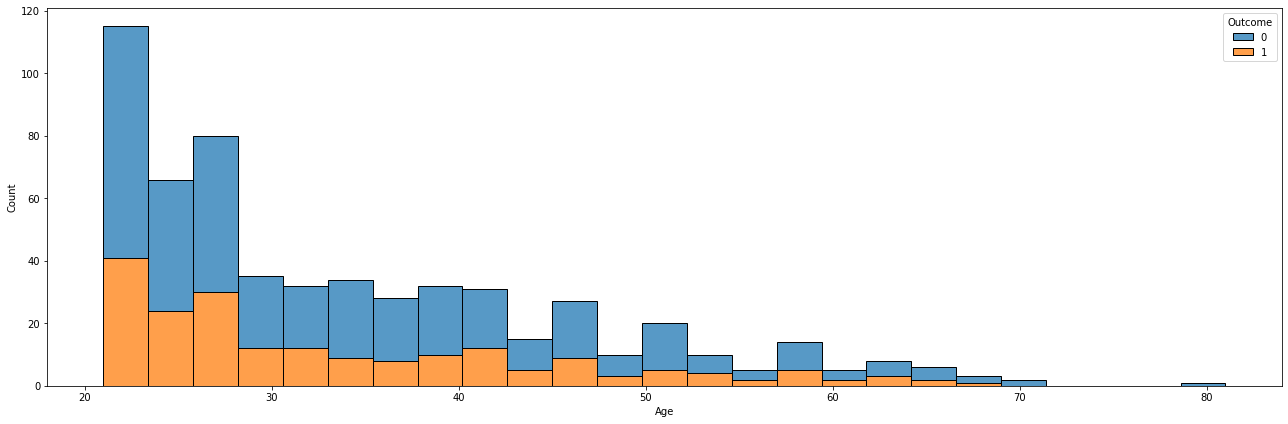

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(data=data,x='Age',hue='Outcome',multiple='stack',bins=25)
fig.tight_layout()

- The dataset sample seemed to be skewed with a majority bieng younger adults.

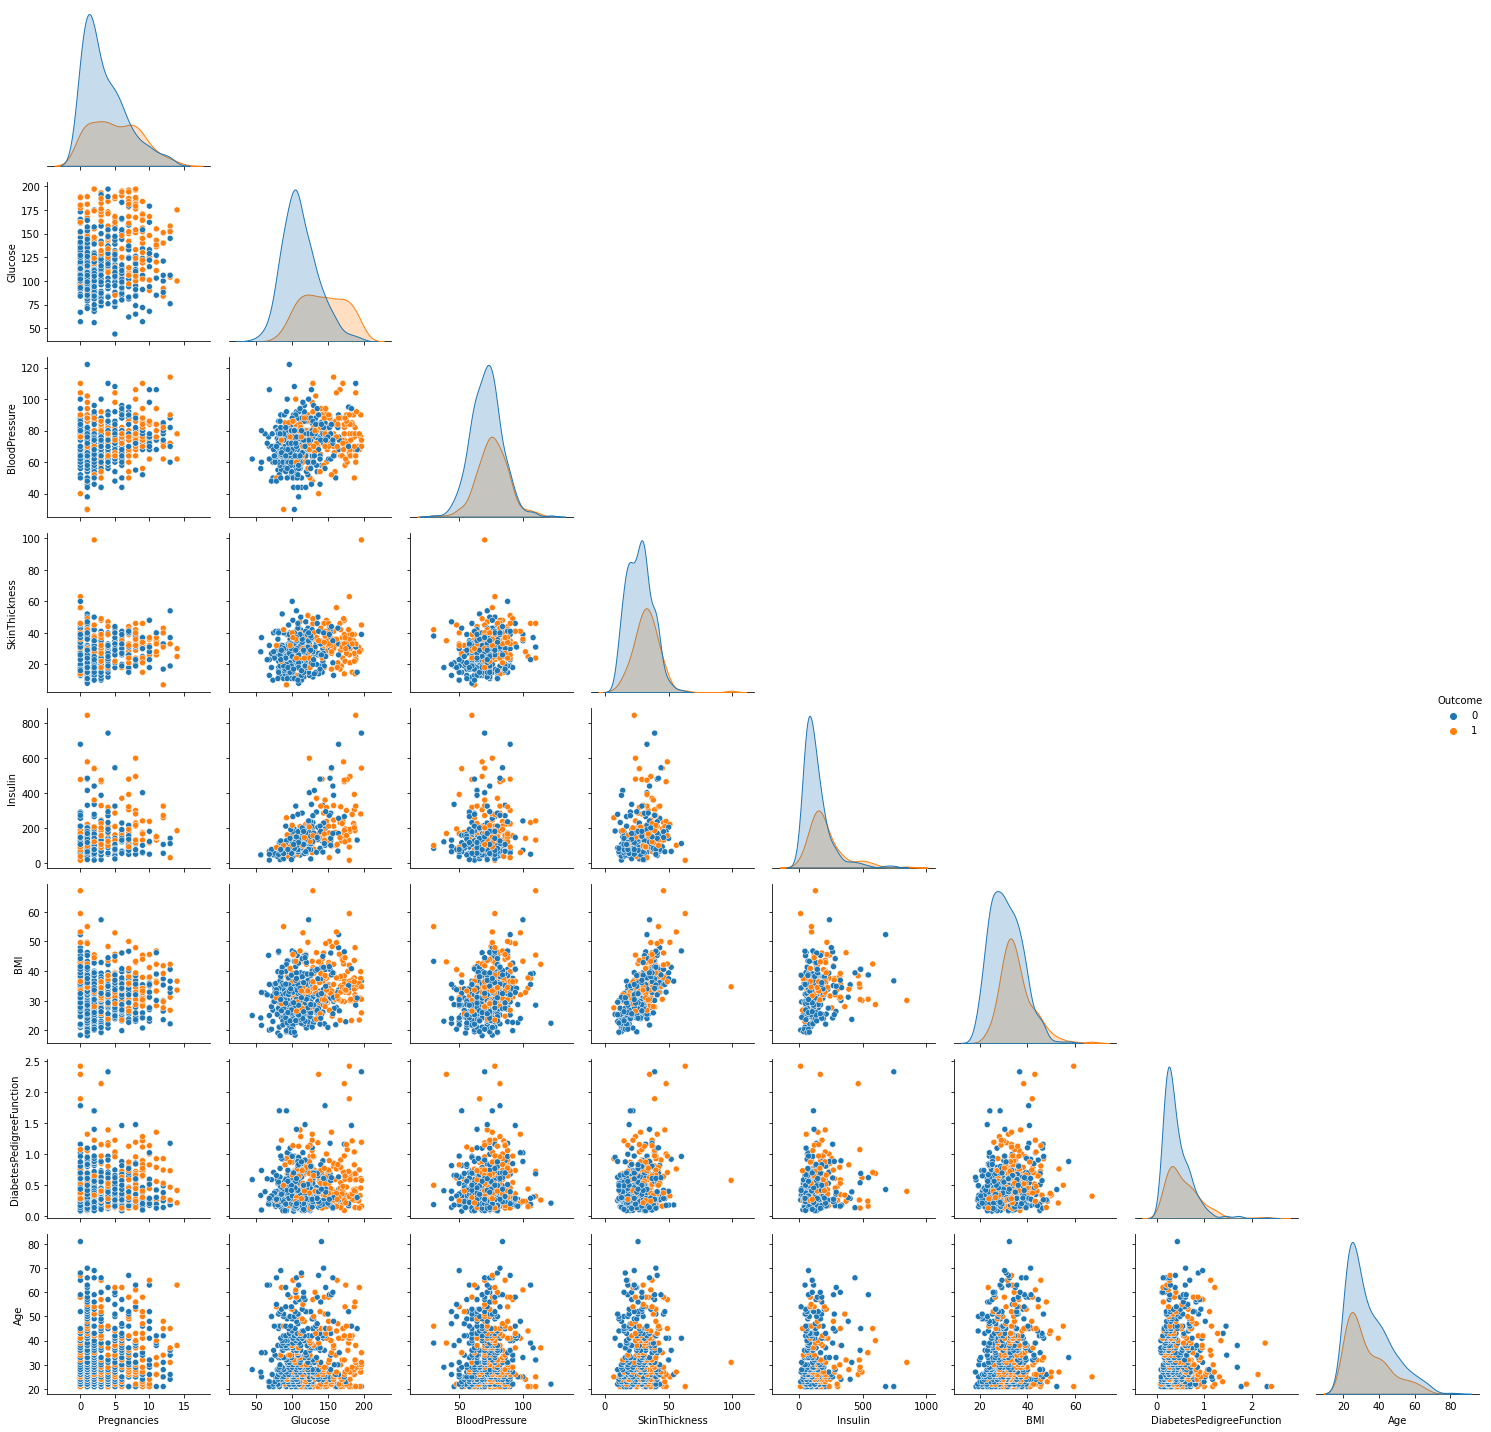

In [ ]:
sns.pairplot(hue='Outcome',data=data,corner=True)
plt.tight_layout()

- From the scatterplots, we can infer that
    - Outcome tends to be 1 (Diabetes +) for higher glucose levels 
    - Skin Thickness,BMI and Insulin,Glicose seems to have some linear relation.



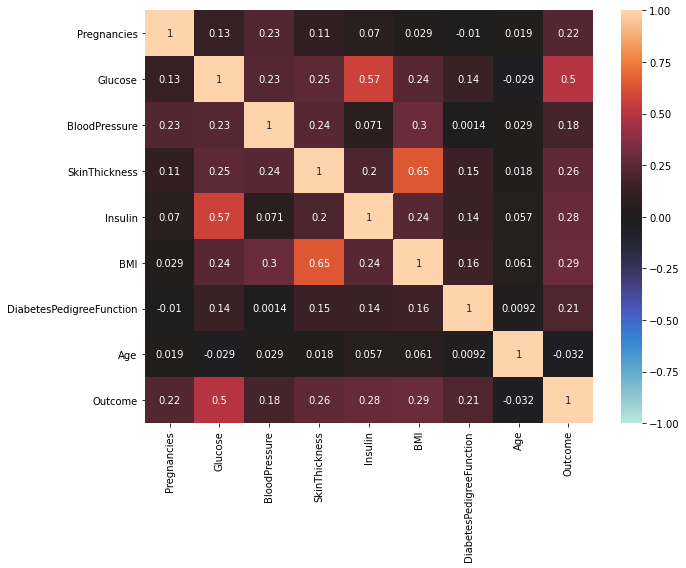

In [ ]:
data_corr = data.corr()
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(data_corr,vmax=1,vmin=-1,annot=True,cmap=sns.color_palette("icefire", as_cmap=True))
fig.tight_layout()

In [ ]:
print("Correlation of Features with 'Outcome' \n")
data_corr.iloc[:-1,-1].sort_values(ascending=False)

Correlation of Features with 'Outcome' 



Glucose                     0.495278
BMI                         0.292687
Insulin                     0.284970
SkinThickness               0.260043
Pregnancies                 0.224781
DiabetesPedigreeFunction    0.211482
BloodPressure               0.182975
Age                        -0.032073
Name: Outcome, dtype: float64

In [ ]:
print("Correlation within Features  \n")
for i,y in enumerate(data_corr.index):
    for j,x in enumerate(data_corr.columns.drop('Outcome')):
        if(j<i):
            continue
        if ((data_corr.loc[x,y] >0.4) or (data_corr.loc[x,y] <-0.4)) and x!=y:
            print(f'{x} - {y}  : {data_corr.loc[x,y]}')

Correlation within Features  

Insulin - Glucose  : 0.5699749117606373
BMI - SkinThickness  : 0.6451013845968181


- Both our inferences from the scatterplot is correct as validated by the Pearson's Correlation.

We will now impute the missing values in SkinThickness and Insulin.

In [ ]:
print("Number of Missing Values in :","\n")
for feature in data.columns:
  if data[feature].isin([np.nan]).sum()>1:
    print(f"  - {feature} :", data[feature].isna().sum(),f"({data[feature].isna().sum()*100/len(data):0.2f} %)")


Number of Missing Values in : 

  - SkinThickness : 154 (26.60 %)
  - Insulin : 272 (46.98 %)


# Model Selection

Our objective is to predict if a patient/person is likely to have diabetes. For early diagnosis and treatment purposes, we should avoid missing out positive (likely to be diabetic) cases. Hence **Recall is more important** than Precision.

Also since the dataset is mildly imbalanced **PR-AUC or  Average Precision score** can be considered as over ROC-AUC score for model comparison.

In [ ]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix,average_precision_score,f1_score,precision_recall_curve,auc,recall_score,precision_score,plot_confusion_matrix,classification_report,accuracy_score,roc_auc_score

In [ ]:
models = {}

## XGBoost

In [ ]:
xgb_boost_rounds = []
y_counts = y_train.value_counts()

def objective_xgb(trial):
  
  learning_params = dict(max_depth=trial.suggest_int('max_depth',1,21,step=2),
  learning_rate=trial.suggest_categorical('learning_rate',[0.001,0.01,0.1,0.2,0.3]),
  gamma=trial.suggest_categorical('gamma',[0,1,2,3,5,10,20]),
  min_child_weight=trial.suggest_int('min_child_weight',0,50),
  subsample=trial.suggest_float('subsample',0.4,1,step=0.05),
  colsample_bytree=trial.suggest_float('colsample_bytree',0.4,1,step=0.05))
  
  params = dict(objective='binary:logistic',n_jobs=-1 , missing=np.nan,
                scale_pos_weight=y_counts[0]/y_counts[1], random_state=21)
  params.update(learning_params)
  
  dtrain = xgb.DMatrix(X_train,y_train)

  cv_score = xgb.cv(params,dtrain,num_boost_round=1000, nfold=5, stratified=True,metrics='aucpr', early_stopping_rounds=50,seed=21)
  xgb_boost_rounds.append(len(cv_score))

  return cv_score['test-aucpr-mean'].iloc[-1]

In [ ]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb,120)

best_trial_xgb = study_xgb.best_trial

[I 2021-07-08 19:10:37,245] A new study created in memory with name: no-name-546dd96d-fd7b-4416-ac50-034e2d5e9cf6
[I 2021-07-08 19:10:37,545] Trial 0 finished with value: 0.6909908 and parameters: {'max_depth': 19, 'learning_rate': 0.1, 'gamma': 20, 'min_child_weight': 22, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001}. Best is trial 0 with value: 0.6909908.
[I 2021-07-08 19:10:37,777] Trial 1 finished with value: 0.6712185999999999 and parameters: {'max_depth': 7, 'learning_rate': 0.3, 'gamma': 5, 'min_child_weight': 35, 'subsample': 0.8, 'colsample_bytree': 0.9500000000000001}. Best is trial 0 with value: 0.6909908.
[I 2021-07-08 19:10:37,985] Trial 2 finished with value: 0.6784665999999999 and parameters: {'max_depth': 21, 'learning_rate': 0.1, 'gamma': 20, 'min_child_weight': 46, 'subsample': 0.9500000000000001, 'colsample_bytree': 0.75}. Best is trial 0 with value: 0.6909908.
[I 2021-07-08 19:10:38,161] Trial 3 finished with value: 0.7175584 and parameter

In [ ]:
print("Best Score : ", best_trial_xgb.value)
print("Best Score Params : ", best_trial_xgb.params)
print("Best Score n Boosts: ", xgb_boost_rounds[best_trial_xgb.number])

Best Score :  0.7352722
Best Score Params :  {'max_depth': 21, 'learning_rate': 0.001, 'gamma': 3, 'min_child_weight': 13, 'subsample': 0.55, 'colsample_bytree': 0.45}
Best Score n Boosts:  10


In [ ]:
xgb_boost_rounds[best_trial_xgb.number]

10

In [ ]:
xgb_clf = xgb.XGBClassifier(**best_trial_xgb.params, n_estimators=xgb_boost_rounds[best_trial_xgb.number], n_jobs=-1, missing=np.nan, scale_pos_weight=(y_counts[0]/y_counts[1]))
xgb_clf.fit(X_train,y_train,)
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=3,
              learning_rate=0.001, max_delta_step=0, max_depth=21,
              min_child_weight=13, missing=None, n_estimators=10, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8691588785046729,
              seed=None, silent=None, subsample=0.55, verbosity=1)

In [ ]:
y_scores_xgb = cross_val_predict(xgb_clf,X_train,y_train,cv=4,method='predict_proba')

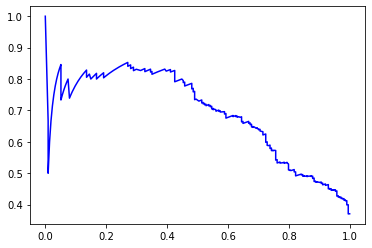

In [ ]:
precision, recall, threshold = precision_recall_curve(y_train,y_scores_xgb[:,1])
plt.plot(recall,precision,'b-')

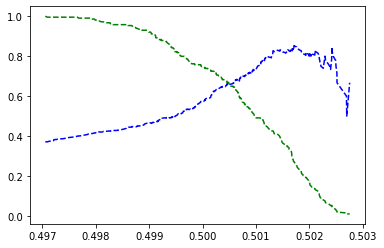

In [ ]:
plt.plot(threshold,recall[:-1],'g--',label='Recall')
plt.plot(threshold,precision[:-1],'b--',label='Precision')

In [ ]:
y_pred_xgb = xgb_clf.predict(X_test,validate_features=False)
y_pred_xgb

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
print(average_precision_score(y_test,y_pred_xgb))
print(f1_score(y_test,y_pred_xgb))
print(precision_score(y_test,y_pred_xgb))
print(recall_score(y_test,y_pred_xgb),'\n')
print(classification_report(y_test,y_pred_xgb))

0.5915546441862232
0.7027027027027027
0.6842105263157895
0.7222222222222222 

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       100
           1       0.68      0.72      0.70        54

    accuracy                           0.79       154
   macro avg       0.76      0.77      0.77       154
weighted avg       0.79      0.79      0.79       154



In [ ]:
confusion_matrix(y_test,y_pred_xgb)

array([[82, 18],
       [15, 39]])

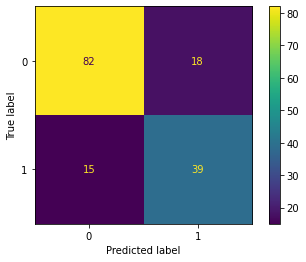

In [ ]:
plot_confusion_matrix(xgb_clf,X_test,y_test)

In [ ]:
models.update({'XGBoost Classifier (pre-imputed)':xgb_clf})

# Imputing

In [ ]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
114,7,160.0,54.0,32.0,175.0,30.5,0.588,21,1
686,3,130.0,64.0,NaN,NaN,23.1,0.314,21,0
662,8,167.0,106.0,46.0,231.0,37.6,0.165,21,1
58,0,146.0,82.0,NaN,NaN,40.5,1.781,21,0
247,0,165.0,90.0,33.0,680.0,52.3,0.427,21,0
...,...,...,...,...,...,...,...,...,...
756,7,137.0,90.0,41.0,NaN,32.0,0.391,67,0
200,0,113.0,80.0,16.0,NaN,31.0,0.874,68,0
508,2,84.0,50.0,23.0,76.0,30.4,0.968,69,0
470,1,144.0,82.0,40.0,NaN,41.3,0.607,70,0


In [ ]:
missing_count(data)

Number of Instances :  579
Number of Missing Values in :
  - SkinThickness : 154 (26.60 %)
  - Insulin : 272 (46.98 %)


In [ ]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.impute import KNNImputer

In [ ]:
data_impute = data.copy()

In [ ]:
scaler_fr_imputer = RobustScaler()
scaled_intermediate = scaler_fr_imputer.fit_transform(X=data_impute.iloc[:,:-1])
imputer = KNNImputer()
imputed_X = imputer.fit_transform(scaled_intermediate)
imputed_X = scaler_fr_imputer.inverse_transform(imputed_X)
pd.DataFrame(imputed_X)

,0,1,2,3,4,5,6,7
0,7.0,160.0,54.0,32.0,175.0,30.5,0.588,21.0
1,3.0,130.0,64.0,20.6,148.4,23.1,0.314,21.0
2,8.0,167.0,106.0,46.0,231.0,37.6,0.165,21.0
3,0.0,146.0,82.0,42.4,235.4,40.5,1.781,21.0
4,0.0,165.0,90.0,33.0,680.0,52.3,0.427,21.0
...,...,...,...,...,...,...,...,...
574,7.0,137.0,90.0,41.0,265.6,32.0,0.391,67.0
575,0.0,113.0,80.0,16.0,127.4,31.0,0.874,68.0
576,2.0,84.0,50.0,23.0,76.0,30.4,0.968,69.0
577,1.0,144.0,82.0,40.0,253.0,41.3,0.607,70.0


In [ ]:
scaler = RobustScaler()
imputed_data = scaler.fit_transform(imputed_X)

In [ ]:
X_train_Imputed = imputed_data
y_train_Imputed =  data_impute.iloc[:,-1]
test_Imputed = pd.concat([X_test,y_test],axis='columns').dropna()
X_test_Imputed1 = test_Imputed.drop('Outcome',axis='columns')
X_test_Imputed = scaler.transform(X_test_Imputed1)
y_test_Imputed = test_Imputed['Outcome']

## Dataset Linearly Seperable or Not !?

We could check if the dataset is linearly seperable using a Hard-Margin LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
linSVC = LinearSVC(C=1000,max_iter=100000)
linSVC.fit(X_train_Imputed,y_train_Imputed)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC(C=1000, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
linSVC.score(X_train_Imputed,y_train_Imputed)

0.7875647668393783

- As we can see, the Liblinear kernal failed to converge and also the accuracy score is just 78%.

We can conclude that the dataset is not linearly seperable.

## K Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def objective_knn(trial):

  n_neighbors=trial.suggest_int('n_neighbors', 3, 25)
  weights=trial.suggest_categorical('weights',['uniform', 'distance'])
  algorithm=trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute'])
  leaf_size=trial.suggest_int('leaf_size',10,80)

  clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size)

  return cross_val_score(clf,X_train_Imputed,y_train_Imputed,scoring='average_precision', cv=5, n_jobs=-1).mean()

In [ ]:
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn,120)

best_trial_knn = study_knn.best_trial

[I 2021-07-08 19:11:14,669] A new study created in memory with name: no-name-259217cf-d3b0-4a74-a021-4692b837b158
[I 2021-07-08 19:11:16,113] Trial 0 finished with value: 0.6917122158596668 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 41}. Best is trial 0 with value: 0.6917122158596668.
[I 2021-07-08 19:11:16,149] Trial 1 finished with value: 0.7144641267934291 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 16}. Best is trial 1 with value: 0.7144641267934291.
[I 2021-07-08 19:11:16,183] Trial 2 finished with value: 0.6134490837116096 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 59}. Best is trial 1 with value: 0.7144641267934291.
[I 2021-07-08 19:11:16,220] Trial 3 finished with value: 0.640966507356642 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 22}. Best is trial 1 with value: 0.714464126793

In [ ]:
print("Best Score : ", best_trial_knn.value)
print("Best Score Params : ", best_trial_knn.params)

Best Score :  0.7160981275080716
Best Score Params :  {'n_neighbors': 21, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 50}


In [ ]:
knn_clf = KNeighborsClassifier(**best_trial_knn.params, n_jobs=-1)
knn_clf.fit(X_train_Imputed,y_train_Imputed)
knn_clf

KNeighborsClassifier(algorithm='kd_tree', leaf_size=50, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=21, p=2,
                     weights='distance')

In [ ]:
y_scores_knn = cross_val_predict(knn_clf,X_train_Imputed,y_train_Imputed,cv=3,method='predict_proba')

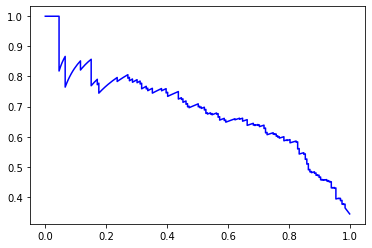

In [ ]:
precision, recall, threshold = precision_recall_curve(y_train_Imputed,y_scores_knn[:,1])
plt.plot(recall,precision,'b-')

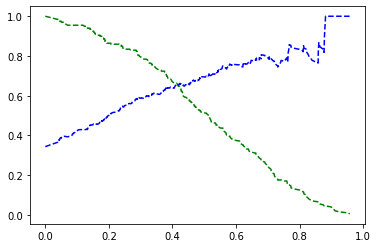

In [ ]:
plt.plot(threshold,recall[:-1],'g--',label='Recall')
plt.plot(threshold,precision[:-1],'b--',label='Precision')

In [ ]:
y_pred_knn = knn_clf.predict(X_test_Imputed)
y_pred_knn

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
print(average_precision_score(y_test_Imputed,y_pred_knn))
print(f1_score(y_test_Imputed,y_pred_knn))
print(precision_score(y_test_Imputed,y_pred_knn))
print(recall_score(y_test_Imputed,y_pred_knn),'\n')
print(classification_report(y_test_Imputed,y_pred_knn))

0.40670588235294125
0.48888888888888893
0.55
0.44 

              precision    recall  f1-score   support

           0       0.78      0.85      0.82        60
           1       0.55      0.44      0.49        25

    accuracy                           0.73        85
   macro avg       0.67      0.65      0.65        85
weighted avg       0.72      0.73      0.72        85



In [ ]:
confusion_matrix(y_test_Imputed,y_pred_knn)

array([[51,  9],
       [14, 11]])

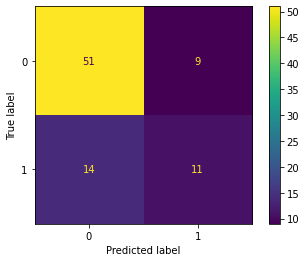

In [ ]:
plot_confusion_matrix(knn_clf,X_test_Imputed,y_test_Imputed)

In [ ]:
models.update({'KNN Classifier':knn_clf})

## Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
def objective_NB(trial):

  var_smoothing=trial.suggest_categorical('var_smoothing', [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0,1e+1,1e+2,1e+3,1e+4,1e+5,1e+6,1e+7,1e+8,1e+9,1e+10,1e+11,1e+12])

  clf = GaussianNB(var_smoothing=var_smoothing)

  return cross_val_score(clf,X_train_Imputed,y_train_Imputed,scoring='average_precision', cv=5, n_jobs=-1).mean()

In [ ]:
study_NB = optuna.create_study(direction='maximize')
study_NB.optimize(objective_NB,50)

best_trial_NB = study_NB.best_trial

[I 2021-07-08 19:11:22,248] A new study created in memory with name: no-name-677f40c2-8305-4702-a968-7b0f1f87f493
[I 2021-07-08 19:11:22,292] Trial 0 finished with value: 0.681003158287331 and parameters: {'var_smoothing': 100000000000.0}. Best is trial 0 with value: 0.681003158287331.
[I 2021-07-08 19:11:22,324] Trial 1 finished with value: 0.686960116673575 and parameters: {'var_smoothing': 1e-09}. Best is trial 1 with value: 0.686960116673575.
[I 2021-07-08 19:11:22,354] Trial 2 finished with value: 0.6813250504848368 and parameters: {'var_smoothing': 100000.0}. Best is trial 1 with value: 0.686960116673575.
[I 2021-07-08 19:11:22,388] Trial 3 finished with value: 0.6813250504848368 and parameters: {'var_smoothing': 100000000.0}. Best is trial 1 with value: 0.686960116673575.
[I 2021-07-08 19:11:22,416] Trial 4 finished with value: 0.686960116673575 and parameters: {'var_smoothing': 0.0001}. Best is trial 1 with value: 0.686960116673575.
[I 2021-07-08 19:11:22,446] Trial 5 finished 

In [ ]:
print("Best Score : ", best_trial_NB.value)
print("Best Score Params : ", best_trial_NB.params)

Best Score :  0.6873250488973442
Best Score Params :  {'var_smoothing': 0.01}


In [ ]:
nb_clf = GaussianNB(**best_trial_NB.params)
nb_clf.fit(X_train_Imputed,y_train_Imputed)
nb_clf

GaussianNB(priors=None, var_smoothing=0.01)

In [ ]:
y_scores_nb = cross_val_predict(nb_clf,X_train_Imputed,y_train_Imputed,cv=3,method='predict_proba')

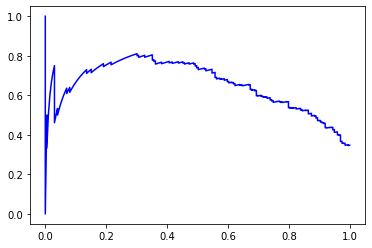

In [ ]:
precision_nb, recall_nb, threshold_nb = precision_recall_curve(y_train_Imputed,y_scores_nb[:,1])
plt.plot(recall_nb,precision_nb,'b-')

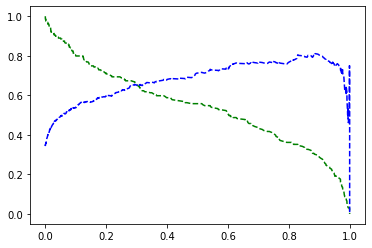

In [ ]:
plt.plot(threshold_nb,recall_nb[:-1],'g--',label='Recall')
plt.plot(threshold_nb,precision_nb[:-1],'b--',label='Precision')

In [ ]:
y_pred_nb = nb_clf.predict(X_test_Imputed)
y_pred_nb

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
print(average_precision_score(y_test_Imputed,y_pred_nb))
print(f1_score(y_test_Imputed,y_pred_nb))
print(precision_score(y_test_Imputed,y_pred_nb))
print(recall_score(y_test_Imputed,y_pred_nb),'\n')
print(classification_report(y_test_Imputed,y_pred_nb))

0.4857754010695187
0.5957446808510639
0.6363636363636364
0.56 

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        60
           1       0.64      0.56      0.60        25

    accuracy                           0.78        85
   macro avg       0.73      0.71      0.72        85
weighted avg       0.77      0.78      0.77        85



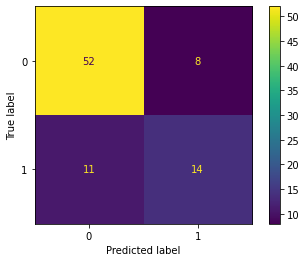

In [ ]:
plot_confusion_matrix(nb_clf,X_test_Imputed,y_test_Imputed)

In [ ]:
models.update({'GaussianNB Classifier':nb_clf})

## XGBoost II

In [ ]:
xgb_boost_rounds_2 = []
y_counts_2 = y_train_Imputed.value_counts()

def objective_xgb_2(trial):
  
  learning_params = dict(max_depth=trial.suggest_int('max_depth',1,21,step=2),
    learning_rate=trial.suggest_categorical('learning_rate',[0.001,0.01,0.1,0.2,0.3]),
    gamma=trial.suggest_categorical('gamma',[0,1,2,3,5,10,20]),
    min_child_weight=trial.suggest_int('min_child_weight',0,50),
    subsample=trial.suggest_float('subsample',0.4,1,step=0.05),
    colsample_bytree=trial.suggest_float('colsample_bytree',0.4,1,step=0.05))
  
  params = dict(objective='binary:logistic',n_jobs=-1 , missing=np.nan,
                scale_pos_weight=y_counts[0]/y_counts[1], random_state=21)
  params.update(learning_params)
  
  dtrain = xgb.DMatrix(X_train_Imputed,y_train_Imputed)

  cv_score = xgb.cv(params,dtrain,num_boost_round=1000, nfold=5, stratified=True,metrics='aucpr', early_stopping_rounds=50,seed=21)
  xgb_boost_rounds_2.append(len(cv_score))

  return cv_score['test-aucpr-mean'].iloc[-1]

In [ ]:
study_xgb_2 = optuna.create_study(direction='maximize')
study_xgb_2.optimize(objective_xgb_2,120)

best_trial_xgb_2 = study_xgb_2.best_trial

[I 2021-07-08 19:11:24,631] A new study created in memory with name: no-name-30713e2f-9191-4a70-81ff-e3f9ec6fb4de
[I 2021-07-08 19:11:24,971] Trial 0 finished with value: 0.7167832000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.3, 'gamma': 10, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.7000000000000001}. Best is trial 0 with value: 0.7167832000000001.
[I 2021-07-08 19:11:25,451] Trial 1 finished with value: 0.7146944 and parameters: {'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'min_child_weight': 0, 'subsample': 0.55, 'colsample_bytree': 0.9500000000000001}. Best is trial 0 with value: 0.7167832000000001.
[I 2021-07-08 19:11:25,565] Trial 2 finished with value: 0.3436884 and parameters: {'max_depth': 15, 'learning_rate': 0.2, 'gamma': 2, 'min_child_weight': 40, 'subsample': 0.45, 'colsample_bytree': 0.6000000000000001}. Best is trial 0 with value: 0.7167832000000001.
[I 2021-07-08 19:11:25,932] Trial 3 finished with value: 0.6699754 and parameter

In [ ]:
print("Best Score : ", best_trial_xgb_2.value)
print("Best Score Params : ", best_trial_xgb_2.params)

Best Score :  0.7529546
Best Score Params :  {'max_depth': 3, 'learning_rate': 0.2, 'gamma': 3, 'min_child_weight': 6, 'subsample': 0.9, 'colsample_bytree': 1.0}


In [ ]:
xgb_clf2 = xgb.XGBClassifier(**best_trial_xgb_2.params, n_estimators=xgb_boost_rounds_2[best_trial_xgb_2.number], n_jobs=-1, missing=np.nan, scale_pos_weight=(y_counts[0]/y_counts[1]))
xgb_clf2.fit(X_train_Imputed,y_train_Imputed)
xgb_clf2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=3,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=6, missing=None, n_estimators=16, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8691588785046729,
              seed=None, silent=None, subsample=0.9, verbosity=1)

In [ ]:
y_scores_xgb2 = cross_val_predict(xgb_clf2,X_train_Imputed,y_train_Imputed,cv=3,method='predict_proba')
y_scores_xgb2

array([[0.09954393, 0.9004561 ],
       [0.83020383, 0.16979615],
       [0.1668064 , 0.8331936 ],
       ...,
       [0.8129353 , 0.1870647 ],
       [0.21220803, 0.78779197],
       [0.32935745, 0.67064255]], dtype=float32)

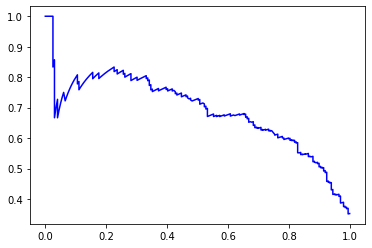

In [ ]:
precision_xgb2, recall_xgb2, threshold_xgb2 = precision_recall_curve(y_train_Imputed,y_scores_xgb2[:,1])
plt.plot(recall_xgb2,precision_xgb2,'b-')

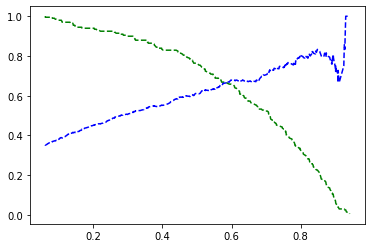

In [ ]:
plt.plot(threshold_xgb2,recall_xgb2[:-1],'g--',label='Recall')
plt.plot(threshold_xgb2,precision_xgb2[:-1],'b--',label='Precision')

In [ ]:
y_pred_xgb2 = xgb_clf2.predict(X_test_Imputed,validate_features=False)
y_pred_xgb2

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
print(average_precision_score(y_test_Imputed,y_pred_xgb2))
print(f1_score(y_test_Imputed,y_pred_xgb2))
print(precision_score(y_test_Imputed,y_pred_xgb2))
print(recall_score(y_test_Imputed,y_pred_xgb2),'\n')
print(classification_report(y_test_Imputed,y_pred_xgb2))

0.4794509803921569
0.6181818181818183
0.5666666666666667
0.68 

              precision    recall  f1-score   support

           0       0.85      0.78      0.82        60
           1       0.57      0.68      0.62        25

    accuracy                           0.75        85
   macro avg       0.71      0.73      0.72        85
weighted avg       0.77      0.75      0.76        85



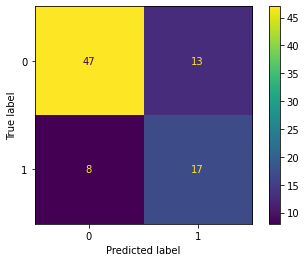

In [ ]:
plot_confusion_matrix(xgb_clf2,X_test_Imputed,y_test_Imputed)

In [ ]:
models.update({'XGBoost Classifier II':xgb_clf2})

## Support Vector Classifier

In [ ]:
from sklearn.svm import SVC

In [ ]:
SVC()

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
def objective_svc(trial):

  gamma = trial.suggest_categorical('gamma',['scale', 'auto'])
  kernal = trial.suggest_categorical('kernel',['poly', 'rbf'])
  C = trial.suggest_categorical('C',[0.0001,0.001,0.01,0.1,1,2,3,5,10,15])
  degree = trial.suggest_int('degree',2,10)
  coef0 = trial.suggest_int('coef0',-5,5)

  clf = SVC(C=C, kernel=kernal, degree=degree, gamma=gamma, coef0=coef0, probability=True, class_weight='balanced', decision_function_shape='ovr', break_ties=True, random_state=21)

  return cross_val_score(clf,X_train_Imputed,y_train_Imputed,scoring='average_precision', cv=5, n_jobs=-1).mean()

In [ ]:
study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(objective_svc,120)

best_trial_svc = study_svc.best_trial

[I 2021-07-08 19:12:02,297] A new study created in memory with name: no-name-b32cd395-98df-43ed-9cf7-221240540c1a
[I 2021-07-08 19:12:02,600] Trial 0 finished with value: 0.6516276051628505 and parameters: {'gamma': 'scale', 'kernel': 'rbf', 'C': 15, 'degree': 9, 'coef0': 4}. Best is trial 0 with value: 0.6516276051628505.
[I 2021-07-08 19:12:03,198] Trial 1 finished with value: 0.5445627354139211 and parameters: {'gamma': 'scale', 'kernel': 'poly', 'C': 2, 'degree': 9, 'coef0': 2}. Best is trial 0 with value: 0.6516276051628505.
[I 2021-07-08 19:12:03,385] Trial 2 finished with value: 0.746544109222762 and parameters: {'gamma': 'auto', 'kernel': 'rbf', 'C': 2, 'degree': 3, 'coef0': -5}. Best is trial 2 with value: 0.746544109222762.
[I 2021-07-08 19:12:03,669] Trial 3 finished with value: 0.7264878152989159 and parameters: {'gamma': 'scale', 'kernel': 'rbf', 'C': 0.001, 'degree': 9, 'coef0': -5}. Best is trial 2 with value: 0.746544109222762.
[I 2021-07-08 19:12:03,914] Trial 4 finish

In [ ]:
print("Best Score : ", best_trial_svc.value)
print("Best Score Params : ", best_trial_svc.params)

Best Score :  0.7518765129692082
Best Score Params :  {'gamma': 'auto', 'kernel': 'rbf', 'C': 1, 'degree': 4, 'coef0': -3}


In [ ]:
svc_clf = SVC(gamma='auto', kernel='rbf',C=1,probability=True, class_weight='balanced', decision_function_shape='ovr', break_ties=True, random_state=21)
svc_clf.fit(X_train_Imputed,y_train_Imputed)
svc_clf

SVC(C=1, break_ties=True, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=21, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_scores_svc = cross_val_predict(svc_clf,X_train_Imputed,y_train_Imputed,cv=3,method='predict_proba')

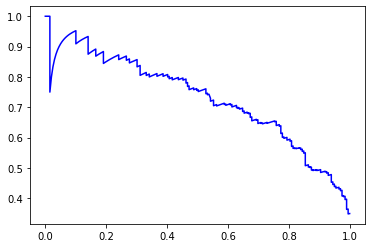

In [ ]:
precision_svc, recall_svc, threshold_svc = precision_recall_curve(y_train_Imputed,y_scores_svc[:,1])
plt.plot(recall_svc,precision_svc,'b-')

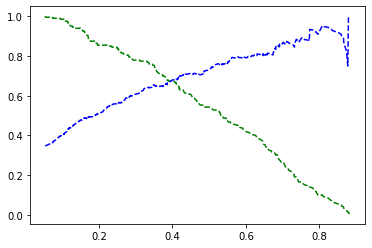

In [ ]:
plt.plot(threshold_svc,recall_svc[:-1],'g--',label='Recall')
plt.plot(threshold_svc,precision_svc[:-1],'b--',label='Precision')

In [ ]:
y_pred_svc = svc_clf.predict(X_test_Imputed)
y_pred_svc

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1])

In [ ]:
print(average_precision_score(y_test_Imputed,y_pred_svc))
print(f1_score(y_test_Imputed,y_pred_svc))
print(precision_score(y_test_Imputed,y_pred_svc))
print(recall_score(y_test_Imputed,y_pred_svc),'\n')
print(classification_report(y_test_Imputed,y_pred_svc))

0.48735294117647054
0.631578947368421
0.5625
0.72 

              precision    recall  f1-score   support

           0       0.87      0.77      0.81        60
           1       0.56      0.72      0.63        25

    accuracy                           0.75        85
   macro avg       0.72      0.74      0.72        85
weighted avg       0.78      0.75      0.76        85



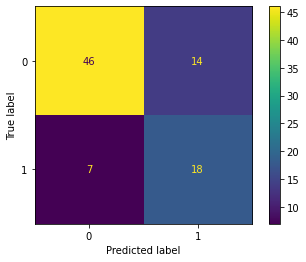

In [ ]:
plot_confusion_matrix(svc_clf,X_test_Imputed,y_test_Imputed)

In [ ]:
models.update({'SVC':svc_clf})

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
 def objective_rfc(trial) :

  max_depth=trial.suggest_int('max_depth',3,31,step=2)
  min_samples_leaf=trial.suggest_int('min_samples_leaf',0,50)
  n_estimators=trial.suggest_int('n_estimators',30,120,step=2)
  max_features=trial.suggest_float('max_features',0.4,1,step=0.05)
  
  clf = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf ,n_estimators=n_estimators, max_features=max_features, class_weight='balanced_subsample',random_state=21)

  return cross_val_score(clf,X_train_Imputed,y_train_Imputed,scoring='average_precision', cv=5, n_jobs=-1).mean()

In [ ]:
study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective_rfc,120)

best_trial_rfc = study_rfc.best_trial

[I 2021-07-08 19:12:28,260] A new study created in memory with name: no-name-1ee1d6f8-865a-404d-8783-9ed5b304a20f
[I 2021-07-08 19:12:29,338] Trial 0 finished with value: 0.7177672831163184 and parameters: {'max_depth': 13, 'min_samples_leaf': 36, 'n_estimators': 104, 'max_features': 0.8}. Best is trial 0 with value: 0.7177672831163184.
[I 2021-07-08 19:12:30,799] Trial 1 finished with value: 0.7184319402444925 and parameters: {'max_depth': 9, 'min_samples_leaf': 32, 'n_estimators': 118, 'max_features': 1.0}. Best is trial 1 with value: 0.7184319402444925.
[I 2021-07-08 19:12:31,851] Trial 2 finished with value: 0.7046925445887251 and parameters: {'max_depth': 13, 'min_samples_leaf': 47, 'n_estimators': 118, 'max_features': 0.4}. Best is trial 1 with value: 0.7184319402444925.
[I 2021-07-08 19:12:32,749] Trial 3 finished with value: 0.7233551530623814 and parameters: {'max_depth': 27, 'min_samples_leaf': 24, 'n_estimators': 92, 'max_features': 0.7000000000000001}. Best is trial 3 with 

In [ ]:
print("Best Score : ", best_trial_rfc.value)
print("Best Score Params : ", best_trial_rfc.params)

Best Score :  0.7308020082959479
Best Score Params :  {'max_depth': 5, 'min_samples_leaf': 17, 'n_estimators': 114, 'max_features': 0.55}


In [ ]:
rf_clf = RandomForestClassifier(**best_trial_rfc.params,class_weight='balanced',oob_score=True,random_state=21)
rf_clf.fit(X_train_Imputed,y_train_Imputed)
rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features=0.55,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=17, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=114,
                       n_jobs=None, oob_score=True, random_state=21, verbose=0,
                       warm_start=False)

In [ ]:
y_scores_rfc = cross_val_predict(rf_clf,X_train_Imputed,y_train_Imputed,cv=3,method='predict_proba')

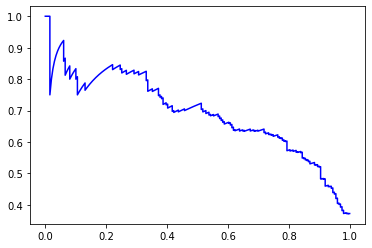

In [ ]:
precision_rfc, recall_rfc, threshold_rfc = precision_recall_curve(y_train_Imputed,y_scores_rfc[:,1])
plt.plot(recall_rfc,precision_rfc,'b-')

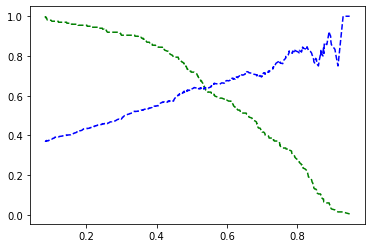

In [ ]:
plt.plot(threshold_rfc,recall_rfc[:-1],'g--',label='Recall')
plt.plot(threshold_rfc,precision_rfc[:-1],'b--',label='Precision')

In [ ]:
y_pred_rfc = rf_clf.predict(X_test_Imputed)
y_pred_rfc

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
print(average_precision_score(y_test_Imputed,y_pred_rfc))
print(f1_score(y_test_Imputed,y_pred_rfc))
print(precision_score(y_test_Imputed,y_pred_rfc))
print(recall_score(y_test_Imputed,y_pred_rfc),'\n')
print(classification_report(y_test_Imputed,y_pred_rfc))

0.5143529411764706
0.6545454545454547
0.6
0.72 

              precision    recall  f1-score   support

           0       0.87      0.80      0.83        60
           1       0.60      0.72      0.65        25

    accuracy                           0.78        85
   macro avg       0.74      0.76      0.74        85
weighted avg       0.79      0.78      0.78        85



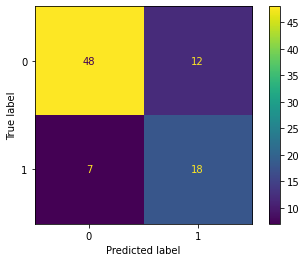

In [ ]:
plot_confusion_matrix(rf_clf,X_test_Imputed,y_test_Imputed)

In [ ]:
models.update({'Random Forest Classifier':rf_clf})

## Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
SGDClassifier()

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
def objective_sgd(trial):

  eta0=trial.suggest_categorical('eta0',[0.001,0.005,0.01,0.05,0.1,0.5,1])
  l1_ratio=trial.suggest_float('l1_ratio', 0,0.9,step=0.1)
  learning_rate=trial.suggest_categorical('learning_rate',['optimal','invscaling','adaptive'] )
  loss=trial.suggest_categorical('loss',['log', 'modified_huber', 'squared_hinge', 'perceptron'])
  alpha=trial.suggest_categorical('alpha',[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1])
  epsilon=trial.suggest_categorical('epsilon',[0.001,0.005,0.01,0.05,0.1,0.2, 0.5,1])

  clf = SGDClassifier(alpha=alpha, class_weight='balanced', epsilon=epsilon, eta0=eta0, 
              l1_ratio=l1_ratio, learning_rate=learning_rate, loss=loss, penalty='elasticnet', random_state=21)
  
  return cross_val_score(clf,X_train_Imputed,y_train_Imputed,scoring='average_precision', cv=5, n_jobs=-1).mean()

In [ ]:
study_sgd = optuna.create_study(direction='maximize')
study_sgd.optimize(objective_sgd,120)

best_trial_sgd = study_sgd.best_trial

[I 2021-07-08 19:14:32,589] A new study created in memory with name: no-name-b6da4c9f-1fd9-4c86-92cd-e686b3f74ac6
[I 2021-07-08 19:14:32,644] Trial 0 finished with value: 0.7199803196554643 and parameters: {'eta0': 0.01, 'l1_ratio': 0.5, 'learning_rate': 'invscaling', 'loss': 'modified_huber', 'alpha': 0.05, 'epsilon': 0.2}. Best is trial 0 with value: 0.7199803196554643.
[I 2021-07-08 19:14:32,688] Trial 1 finished with value: 0.343688155922039 and parameters: {'eta0': 0.1, 'l1_ratio': 0.8, 'learning_rate': 'adaptive', 'loss': 'perceptron', 'alpha': 1, 'epsilon': 0.005}. Best is trial 0 with value: 0.7199803196554643.
[I 2021-07-08 19:14:32,723] Trial 2 finished with value: 0.7149372958883683 and parameters: {'eta0': 0.001, 'l1_ratio': 0.1, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'alpha': 0.5, 'epsilon': 0.01}. Best is trial 0 with value: 0.7199803196554643.
[I 2021-07-08 19:14:32,771] Trial 3 finished with value: 0.7312312723334939 and parameters: {'eta0': 0.05, 'l1_rati

In [ ]:
print("Best Score : ", best_trial_sgd.value)
print("Best Score Params : ", best_trial_sgd.params)

Best Score :  0.7347349336254012
Best Score Params :  {'eta0': 1, 'l1_ratio': 0.7000000000000001, 'learning_rate': 'invscaling', 'loss': 'modified_huber', 'alpha': 0.005, 'epsilon': 0.1}


In [ ]:
sgd_clf = SGDClassifier(**best_trial_sgd.params,class_weight='balanced', penalty='elasticnet', random_state=21)
sgd_clf.fit(X_train_Imputed,y_train_Imputed)
sgd_clf

SGDClassifier(alpha=0.005, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.7000000000000001, learning_rate='invscaling',
              loss='modified_huber', max_iter=1000, n_iter_no_change=5,
              n_jobs=None, penalty='elasticnet', power_t=0.5, random_state=21,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [ ]:
y_scores_sgd = cross_val_predict(sgd_clf,X_train_Imputed,y_train_Imputed,cv=3,method='decision_function')

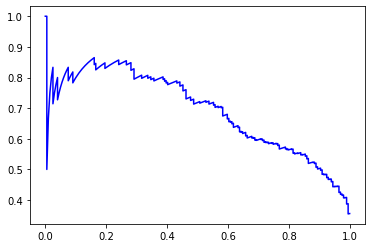

In [ ]:
precision_sgd, recall_sgd, threshold_sgd = precision_recall_curve(y_train_Imputed,y_scores_sgd)
plt.plot(recall_sgd,precision_sgd,'b-')

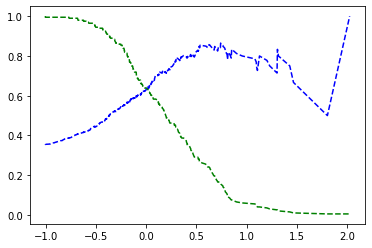

In [ ]:
plt.plot(threshold_sgd,recall_sgd[:-1],'g--',label='Recall')
plt.plot(threshold_sgd,precision_sgd[:-1],'b--',label='Precision')

In [ ]:
y_pred_sgd = sgd_clf.predict(X_test_Imputed)
y_pred_sgd

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
print(average_precision_score(y_test_Imputed,y_pred_sgd))
print(f1_score(y_test_Imputed,y_pred_sgd))
print(precision_score(y_test_Imputed,y_pred_sgd))
print(recall_score(y_test_Imputed,y_pred_sgd),'\n')
print(classification_report(y_test_Imputed,y_pred_sgd))

0.5436720142602496
0.689655172413793
0.6060606060606061
0.8 

              precision    recall  f1-score   support

           0       0.90      0.78      0.84        60
           1       0.61      0.80      0.69        25

    accuracy                           0.79        85
   macro avg       0.75      0.79      0.76        85
weighted avg       0.82      0.79      0.80        85



In [ ]:
confusion_matrix(y_test_Imputed, sgd_clf.predict(X_test_Imputed))

array([[47, 13],
       [ 5, 20]])

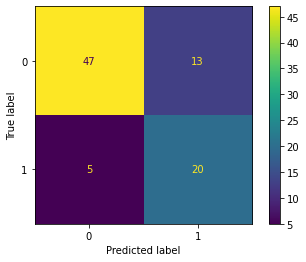

In [ ]:
plot_confusion_matrix(sgd_clf,X_test_Imputed,y_test_Imputed)

In [ ]:
models.update({'SGD Classifier':sgd_clf})

## Comparing Models

In [ ]:
Classification_Model = []
Accuracy = []
Misclassification = []
Sensitivity = []
Specificity =[]
Precision = []
F1_score = []
ROC_AUC_score = []
Average_Precision = []


for modelname,model in models.items():
  
  Classification_Model.append(modelname)

  if modelname=='XGBoost Classifier (pre-imputed)':
    X,y = X_test,y_test
  else:
    X,y = X_test_Imputed,y_test_Imputed
  
  conf_matrix = confusion_matrix(y, model.predict(X))

  TP = conf_matrix[1][1]
  TN = conf_matrix[0][0]
  FP = conf_matrix[0][1]
  FN = conf_matrix[1][0]    

  conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
  Accuracy.append(round(conf_accuracy,3))

  conf_misclassification = 1- conf_accuracy
  Misclassification.append(round(conf_misclassification,3))

  conf_sensitivity = (TP / float(TP + FN))
  Sensitivity.append(round(conf_sensitivity,3))

  conf_specificity = (TN / float(TN + FP))
  Specificity.append(round(conf_specificity,3))

  conf_precision = (TP / float(TP + FP))
  Precision.append(round(conf_precision,3))

  conf_f1 = f1_score(y, model.predict(X))
  F1_score.append(round(conf_f1,3))    
  
  roc_auc = roc_auc_score(y, model.predict(X))
  ROC_AUC_score.append(round(roc_auc,3))

  pr_auc = average_precision_score(y, model.predict(X))
  Average_Precision.append(round(pr_auc,3))

In [ ]:
model_comparison = pd.DataFrame(data=[Accuracy,Misclassification,Sensitivity,Specificity,Precision,F1_score,ROC_AUC_score,Average_Precision],columns=Classification_Model,
                                index=['Accuracy','Misclassification','Sensitivity/Recall','Specificity','Precision','f1_score','ROC_AUC_score','Average_Precision'] ).transpose()
model_comparison

,Accuracy,Misclassification,Sensitivity/Recall,Specificity,Precision,f1_score,ROC_AUC_score,Average_Precision
XGBoost Classifier (pre-imputed),0.786,0.214,0.722,0.820,0.684,0.703,0.771,0.592
KNN Classifier,0.729,0.271,0.440,0.850,0.550,0.489,0.645,0.407
GaussianNB Classifier,0.776,0.224,0.560,0.867,0.636,0.596,0.713,0.486
XGBoost Classifier II,0.753,0.247,0.680,0.783,0.567,0.618,0.732,0.479
SVC,0.753,0.247,0.720,0.767,0.562,0.632,0.743,0.487
Random Forest Classifier,0.776,0.224,0.720,0.800,0.600,0.655,0.760,0.514
SGD Classifier,0.788,0.212,0.800,0.783,0.606,0.690,0.792,0.544


AveragePrecision way to summarize a precision-recall curve. Precision-Recall is a useful measure of success of prediction over ROC-AUC when the classes are very imbalanced. Also we are more concerned about positive class and hence it can be used to compare the perfromance of various models.

- Of all the models trained, **XGBoost Classifier** is the best without the missing data in training set being imputed. Its followed by SGD Classifier.

Recall is more important than Precision in this problem and it can be altered to a degree compramising the Precision.

- Of the models trained, **SGD Classifier** with an rbf Kernal has the highest Recall with the default threshold.

We could conclude that, **XGBoost** is the most suitable model for this dataset.

KNN performed the worst.